In [2]:
import groq
import re
import httpx
import os
from dotenv import load_dotenv
load_dotenv()

from groq import Client,Groq

In [3]:
llm=Groq()

In [ ]:
response=llm.chat.completions.create(
    model='llama-3.1-8b-instant',
    messages=[
        {
            "role": "user",
            "content": "hi, how are you?"
        }
    ],
)
response.choices[0].message.content

"I'm doing well, thank you for asking. I'm a large language model, so I don't have emotions or feelings like humans do, but I'm functioning properly and ready to assist you with any questions or tasks you may have. How can I help you today?"

In [5]:
class Agent:
    def __init__(self,system=""):
        self.system=system
        self.messages=[]
        if system:
            self.messages.append({"role":"system","content":system})
            
    def __call__(self,content):
        self.messages.append({"role":"user","content":content})
        result=self.execute()
        self.messages.append({"role":"assistant","content":result})
        return result
    
    def execute(self):
        completion=llm.chat.completions.create(
            model='llama-3.1-8b-instant',
            messages=self.messages,
            temperature=0,
        )
        return completion.choices[0].message.content

In [6]:
prompt='''
You run in a loop of Thought, Action, PAUSE and Observation.
At the end of the loop you output an answer.
use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observaion will be the result of running those actions.

The actions available to you are :

calculate:
eg : calculate: 4*7/3
Runs a calculation and returns the number - uses python.

average_dog_weight:
eg : average_dog_weight: Collie
returns average weight of a dog when given the breed.

Example session :

Question: How much does a Bulldog weigh ?
Thought: I should look the dogs weight using average_dog_weight.
Action: average_dog_weight: Bulldog
PAUSE

You will be called again with this :

Observation: A Bulldog weighs 51 pounds.

You then output:

Answer: A Bulldog weighs 51 pounds.  
'''.strip()

In [7]:
def calculate(equation):
    return eval(equation)

def average_dog_weight(breed):
    breed=breed.lower()
    dog_weights={'scottish terrier':20,'border collie':37,'toy poodle':7}
    if breed in dog_weights:
        return (f'a {breed.capitalize()} average weight is {dog_weights[breed]} pounds')
    else:
        return ("An average dog weighs 50 pounds.")

In [8]:
known_action={
    'calculate':calculate,
    'average_dog_weight':average_dog_weight
}

In [9]:
bot=Agent(prompt)

In [10]:
result=bot('How much does a Toy Poodle weigh ?')
print(result)

Thought: I should look the Toy Poodle's weight using average_dog_weight.
Action: average_dog_weight: Toy Poodle
PAUSE


In [11]:
for x in bot.messages:
    print(x['content'])

You run in a loop of Thought, Action, PAUSE and Observation.
At the end of the loop you output an answer.
use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observaion will be the result of running those actions.

The actions available to you are :

calculate:
eg : calculate: 4*7/3
Runs a calculation and returns the number - uses python.

average_dog_weight:
eg : average_dog_weight: Collie
returns average weight of a dog when given the breed.

Example session :

Question: How much does a Bulldog weigh ?
Thought: I should look the dogs weight using average_dog_weight.
Action: average_dog_weight: Bulldog
PAUSE

You will be called again with this :

Observation: A Bulldog weighs 51 pounds.

You then output:

Answer: A Bulldog weighs 51 pounds.
How much does a Toy Poodle weigh ?
Thought: I should look the Toy Poodle's weight using average_dog_weight.
Action: average_dog_weight: Toy Poodle


In [12]:
next_prompt=f'Observation: {average_dog_weight('toy poodle')}'

In [13]:
bot(next_prompt)

'Answer: A Toy Poodle weighs 7 pounds.'

In [14]:
bot.messages

[{'role': 'system',
  'content': 'You run in a loop of Thought, Action, PAUSE and Observation.\nAt the end of the loop you output an answer.\nuse Thought to describe your thoughts about the question you have been asked.\nUse Action to run one of the actions available to you - then return PAUSE.\nObservaion will be the result of running those actions.\n\nThe actions available to you are :\n\ncalculate:\neg : calculate: 4*7/3\nRuns a calculation and returns the number - uses python.\n\naverage_dog_weight:\neg : average_dog_weight: Collie\nreturns average weight of a dog when given the breed.\n\nExample session :\n\nQuestion: How much does a Bulldog weigh ?\nThought: I should look the dogs weight using average_dog_weight.\nAction: average_dog_weight: Bulldog\nPAUSE\n\nYou will be called again with this :\n\nObservation: A Bulldog weighs 51 pounds.\n\nYou then output:\n\nAnswer: A Bulldog weighs 51 pounds.'},
 {'role': 'user', 'content': 'How much does a Toy Poodle weigh ?'},
 {'role': 'as

In [15]:
bot=Agent(prompt)

In [16]:
bot.messages

[{'role': 'system',
  'content': 'You run in a loop of Thought, Action, PAUSE and Observation.\nAt the end of the loop you output an answer.\nuse Thought to describe your thoughts about the question you have been asked.\nUse Action to run one of the actions available to you - then return PAUSE.\nObservaion will be the result of running those actions.\n\nThe actions available to you are :\n\ncalculate:\neg : calculate: 4*7/3\nRuns a calculation and returns the number - uses python.\n\naverage_dog_weight:\neg : average_dog_weight: Collie\nreturns average weight of a dog when given the breed.\n\nExample session :\n\nQuestion: How much does a Bulldog weigh ?\nThought: I should look the dogs weight using average_dog_weight.\nAction: average_dog_weight: Bulldog\nPAUSE\n\nYou will be called again with this :\n\nObservation: A Bulldog weighs 51 pounds.\n\nYou then output:\n\nAnswer: A Bulldog weighs 51 pounds.'}]

In [17]:
question='i have 2 dogs, a border collie and a scottish terrier. What is their combined weight ?'
bot(question)

'Thought: I need to find the weight of a Border Collie and a Scottish Terrier, then add them together.\nAction: average_dog_weight: Border Collie\nPAUSE'

In [18]:
next_prompt=f'Observation: {average_dog_weight('Border Collie')}'
bot(next_prompt)

'Thought: Now I need to find the weight of a Scottish Terrier and add it to the weight of the Border Collie.\nAction: average_dog_weight: Scottish Terrier\nPAUSE'

In [19]:
next_prompt=f'Observation: {average_dog_weight('Scottish Terrier')}'
bot(next_prompt)

'Thought: Now that I have the weights of both dogs, I can add them together to find the combined weight.\nAction: calculate: 37 + 20\nPAUSE'

In [20]:
bot('Observation: 57')

'Answer: The combined weight of a Border Collie and a Scottish Terrier is 57 pounds.'

In [21]:
action_re=re.compile(r'^Action: (\w+): (.*)$')
x=action_re.match('Action: average_dog_weight: Toy Poodle')

In [22]:
x.group(2)

'Toy Poodle'

In [23]:
def query(question,max_turns=5):
    i=0
    bot=Agent(prompt)
    next_prompt=question
    while i<max_turns:
        i+=1
        result=bot(next_prompt)
        print(result)
        actions=[
            action_re.match(a)
            for a in result.split('\n')
            if action_re.match(a)
        ]
        if actions:
            action,action_input=actions[0].groups()
            if action not in known_action:
                raise Exception(f'Unknown action: {action}: --running {action} {action_input}')
            observation=known_action[action](action_input)
            print(f'Observation: {observation}')
            next_prompt=f'Observation: {observation}'
        else:
            return
        

In [24]:
question

'i have 2 dogs, a border collie and a scottish terrier. What is their combined weight ?'

In [25]:
query(question)

Thought: I need to find the weight of a Border Collie and a Scottish Terrier, then add them together.
Action: average_dog_weight: Border Collie
PAUSE
Observation: a Border collie average weight is 37 pounds
Thought: Now I need to find the weight of a Scottish Terrier and add it to the weight of the Border Collie.
Action: average_dog_weight: Scottish Terrier
PAUSE
Observation: a Scottish terrier average weight is 20 pounds
Thought: Now that I have the weights of both dogs, I can add them together to find the combined weight.
Action: calculate: 37 + 20
PAUSE
Observation: 57
Answer: The combined weight of a Border Collie and a Scottish Terrier is 57 pounds.


## USING LANGGRAPH

In [26]:
from langgraph.graph import StateGraph,END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults

In [27]:
tool=TavilySearchResults(max_results=2)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [28]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage],operator.add]

In [44]:
class Agent:
    def __init__(self,model,tools,system=""):
        self.system=system
        graph=StateGraph(AgentState)
        graph.add_node("llm",self.call_groq)
        graph.add_node("action",self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.action_exists,
            {True:"action",False:END}
        )
        graph.add_edge("action","llm")
        graph.set_entry_point("llm")
        self.graph=graph.compile()
        self.tools={t.name:t for t in tools}
        self.model=model.bind_tools(tools)
        
    def action_exists(self,state:AgentState):
        result=state['messages'][-1]
        return len(result.tool_calls)>0
        
        
    def call_groq(self,state:AgentState):
        messages=state["messages"]
        if self.system:
            messages=[SystemMessage(content=self.system)] + messages
        message=self.model.invoke(messages)
        return {'messages':[message]}
    
    def take_action(self,state:AgentState):
        tool_calls=state['messages'][-1].tool_calls
        results=[]
        for t in tool_calls:
            print(f'Calling: {t}')
            result=self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t["id"],name=t["name"],content=str(result)))
        print("Back to the Model !!")
        return {"messages":results}
    

In [ ]:
prompt = """You are a smart research assistant. Use the search engine to help answer user questions.
You are allowed to make multiple calls (either together or in sequence).
Only look up information when you are sure of what you want.
If you need to look up some information before asking a follow-up question, do so.
Be efficient and clear in your responses."""

tools=[tool]
abot=Agent(ChatGroq(model='llama3-8b-8192'),tools,prompt)

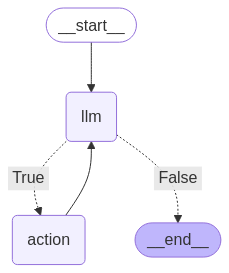

In [46]:
from IPython.display import Image
display(Image(abot.graph.get_graph().draw_mermaid_png()))

In [47]:
messages=[HumanMessage(content="What is the weather in Varanasi ?")]
result=abot.graph.invoke({'messages':messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Varanasi'}, 'id': 'call_vyjv', 'type': 'tool_call'}
Back to the Model !!


In [48]:
result

{'messages': [HumanMessage(content='What is the weather in Varanasi ?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vyjv', 'function': {'arguments': '{"query":"weather in Varanasi"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 1021, 'total_tokens': 1095, 'completion_time': 0.061666667, 'prompt_time': 0.126975026, 'queue_time': 0.23145343200000001, 'total_time': 0.188641693}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_a97cfe35ae', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-14f6a59a-5d0e-4f8e-be59-bbdfc205a70f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Varanasi'}, 'id': 'call_vyjv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1021, 'output_tokens': 74, 'total_tokens': 1095}),
  ToolMessage(content="[{'title': 'Weather in Varanasi in April 20

In [54]:
for x in result['messages'][-1].content.split('.'):
    print(x.strip())

Varanasi weather in April 2025: The weather in Varanasi in April 2025 is expected to be warm with average highs of 100°F (38°C) and lows of 43°F (6°C)
There will be clear skies on Friday, 18 April, with a high of 82°F (28°C) and sunny conditions
On Saturday, 19 April, it will be sunny with a high of 42°F (6°C) and lows of 30°F (-1°C)



In [55]:
messages=[HumanMessage(content="Pakistan vs Sri lanka , which criket team was better in the years 2013-2014 ? How are the geopolitical relations of that country with India ?")]
result=abot.graph.invoke({'messages':messages})
for x in result['messages'][-1].content.split('.'):
    print(x.strip())

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Pakistan vs Sri Lanka cricket 2013-2014'}, 'id': 'call_80bm', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Pakistan-India geopolitics'}, 'id': 'call_0hdf', 'type': 'tool_call'}
Back to the Model !!
Based on the data provided by the tools, it appears that the Pakistan cricket team performed better against Sri Lanka in the years 2013-2014, winning 2 out of the 3 matches
As for the geopolitical relations between Pakistan and India, it is clear that the two nations have had a complex and tumultuous relationship since their independence in 1947
The Kashmir dispute has been a major point of contention, with both countries fighting three major wars and numerous armed skirmishes over the territory
The relationship has also been marked by periods of diplomatic talks and agreements, such as the Lahore Declaration in 1999, but these have often been followed by renewed tensions and conflic